In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Data pre-processing

In [2]:
# Load the Excel data
file_path = 'data.xlsx'
data = pd.read_excel(file_path, sheet_name=None)

# Extract relevant data from the sheets
azip = pd.read_excel(file_path, sheet_name='azip', header=None).values
testzip = pd.read_excel(file_path, sheet_name='testzip', header=None).values

# Reload the 'dzip' and 'dtest' sheets with correct parsing
dzip = pd.read_excel(file_path, sheet_name='dzip', header=None).values.flatten()
dtest = pd.read_excel(file_path, sheet_name='dtest', header=None).values.flatten()

# Display the shapes of the data for verification
(dzip.shape, azip.shape, dtest.shape, testzip.shape)

((1707,), (256, 1707), (2007,), (256, 2007))

In [3]:
# Create a dictionary to hold matrices for each digit class
class_matrices = {i: [] for i in range(10)}

# Populate the class matrices
for i, digit in enumerate(dzip):
    class_matrices[digit].append(azip[:, i])

# Convert lists to numpy arrays
for digit in class_matrices:
    class_matrices[digit] = np.array(class_matrices[digit]).T

    # Ensure each matrix is at least 2D
    if class_matrices[digit].ndim == 1:
        class_matrices[digit] = class_matrices[digit].reshape(-1, 1)

# Verify the shapes of class matrices
class_shapes = {digit: class_matrices[digit].shape for digit in class_matrices}
class_shapes

{0: (256, 319),
 1: (256, 252),
 2: (256, 202),
 3: (256, 131),
 4: (256, 122),
 5: (256, 88),
 6: (256, 151),
 7: (256, 166),
 8: (256, 144),
 9: (256, 132)}

#### SVD

In [4]:
# Compute SVD for each class matrix
class_svds = {}
for digit in class_matrices:
    U, S, Vt = np.linalg.svd(class_matrices[digit], full_matrices=False)
    class_svds[digit] = (U, S, Vt)

# Verify SVD results
svd_shapes = {digit: (U.shape, S.shape, Vt.shape) for digit, (U, S, Vt) in class_svds.items()}
svd_shapes


{0: ((256, 256), (256,), (256, 319)),
 1: ((256, 252), (252,), (252, 252)),
 2: ((256, 202), (202,), (202, 202)),
 3: ((256, 131), (131,), (131, 131)),
 4: ((256, 122), (122,), (122, 122)),
 5: ((256, 88), (88,), (88, 88)),
 6: ((256, 151), (151,), (151, 151)),
 7: ((256, 166), (166,), (166, 166)),
 8: ((256, 144), (144,), (144, 144)),
 9: ((256, 132), (132,), (132, 132))}

#### Classification Accuracy

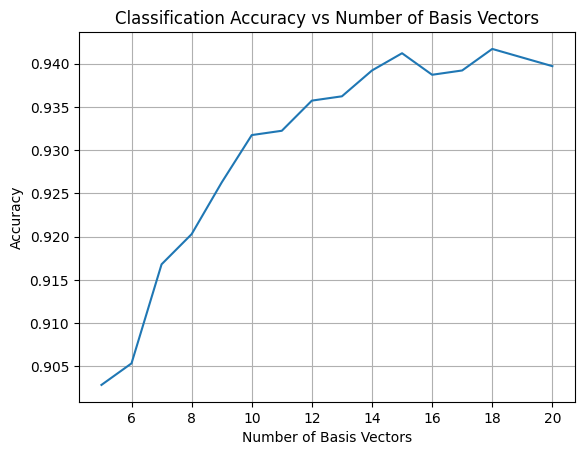

In [5]:
def classify_digit(image, class_svds, num_basis_vectors):
    image = image.flatten()  # Ensure image is a 1D vector
    residuals = {}
    for digit, (U, S, Vt) in class_svds.items():
        U_reduced = U[:, :num_basis_vectors]
        if U_reduced.shape[0] != image.shape[0]:
            continue  # Skip if dimensions do not match
        projection = U_reduced @ U_reduced.T @ image
        residuals[digit] = np.linalg.norm(image - projection)
    return min(residuals, key=residuals.get)

# Test the classifier with different numbers of basis vectors
num_basis_vectors_options = range(5, 21)
accuracy_results = []

for num_basis_vectors in num_basis_vectors_options:
    correct = 0
    for i, test_image in enumerate(testzip.T):
        predicted_digit = classify_digit(test_image, class_svds, num_basis_vectors)
        if predicted_digit == dtest[i]:
            correct += 1
    accuracy = correct / len(dtest)
    accuracy_results.append((num_basis_vectors, accuracy))

# Convert results to DataFrame for better visualization
accuracy_df = pd.DataFrame(accuracy_results, columns=['num_basis_vectors', 'accuracy'])

import matplotlib.pyplot as plt

# Plot the accuracy results
plt.plot(accuracy_df['num_basis_vectors'], accuracy_df['accuracy'])
plt.xlabel('Number of Basis Vectors')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs Number of Basis Vectors')
plt.grid(True)
plt.show()


#### Misclassified Digits and Visualization

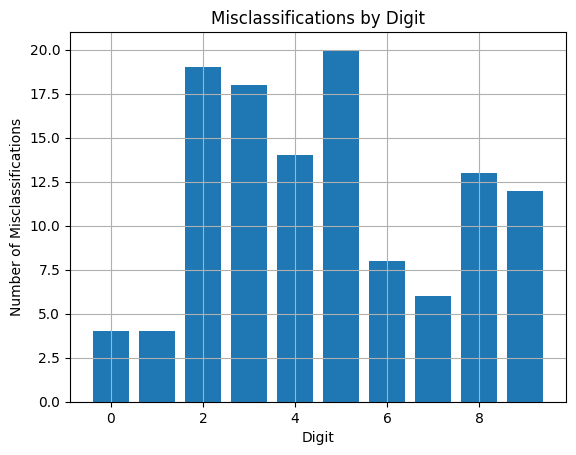

In [6]:
# Check if all digits are equally easy or difficult to classify
difficulty = {digit: 0 for digit in range(10)}

num_basis_vectors = 15  # For instance, choose 15 basis vectors for analysis
for i, test_image in enumerate(testzip.T):
    predicted_digit = classify_digit(test_image, class_svds, num_basis_vectors)
    if predicted_digit != dtest[i]:
        difficulty[dtest[i]] += 1

# Convert difficulty results to DataFrame
difficulty_df = pd.DataFrame(list(difficulty.items()), columns=['digit', 'misclassifications'])

# Plot misclassifications
plt.bar(difficulty_df['digit'], difficulty_df['misclassifications'])
plt.xlabel('Digit')
plt.ylabel('Number of Misclassifications')
plt.title('Misclassifications by Digit')
plt.grid(True)
plt.show()

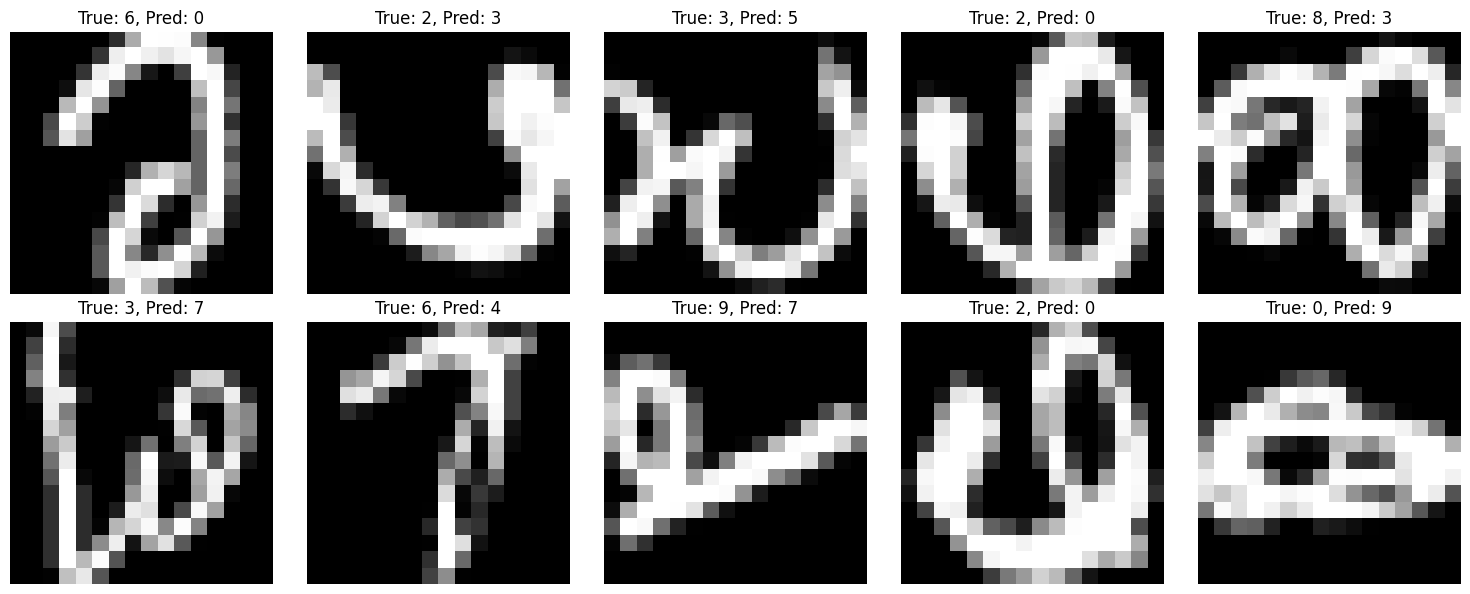

In [7]:
def ima2(images, true_labels, predicted_labels, max_images=10):
    num_images = min(len(images), max_images)
    num_cols = 5
    num_rows = (num_images // num_cols) + int(num_images % num_cols != 0)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()
    
    for idx, (image, true_label, predicted_label) in enumerate(zip(images, true_labels, predicted_labels)):
        if idx >= max_images:
            break
        image_vector = np.squeeze(image)
        image_vector = image_vector - np.min(image_vector)
        image_vector = (20 / np.max(image_vector)) * image_vector
        
        if image_vector.size == 256:
            image_matrix = image_vector.reshape((16, 16)).T
            axes[idx].imshow(image_matrix, cmap='gray', vmin=0, vmax=20)
            axes[idx].set_title(f'True: {true_label}, Pred: {predicted_label}')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, 'Invalid size', horizontalalignment='center', verticalalignment='center')
            axes[idx].set_title(f'True: {true_label}, Pred: {predicted_label}')
            axes[idx].axis('off')
    
    for ax in axes[num_images:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Identify and display misclassified images
num_basis_vectors = 15  # Choose a number of basis vectors for analysis
misclassified_images = []
true_labels = []
predicted_labels = []

for i, test_image in enumerate(testzip.T):
    predicted_digit = classify_digit(test_image, class_svds, num_basis_vectors)
    if predicted_digit != dtest[i] and predicted_digit != -1:
        misclassified_images.append(test_image)
        true_labels.append(dtest[i])
        predicted_labels.append(predicted_digit)

# Display misclassified images
if misclassified_images:
    ima2(misclassified_images, true_labels, predicted_labels, max_images=10)  # Display only the first 10 misclassified images for brevity
else:
    print("No misclassified images to display.")

#### Singular values

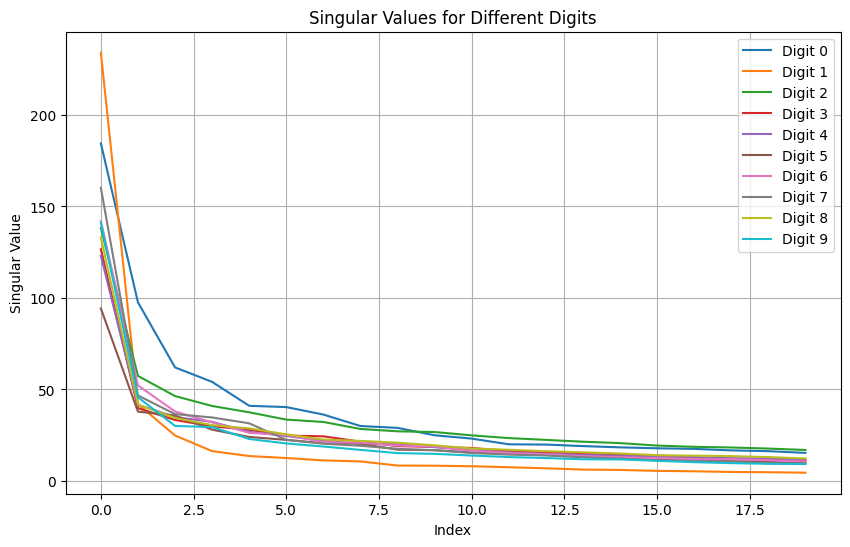

0.9128051818634778

In [8]:
# Examine singular values
singular_values = {digit: S for digit, (U, S, Vt) in class_svds.items()}

# Plot singular values for each class
plt.figure(figsize=(10, 6))
for digit, S in singular_values.items():
    plt.plot(S[:20], label=f'Digit {digit}')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values for Different Digits')
plt.legend()
plt.grid(True)
plt.show()

# Determine optimal number of basis vectors for each class
optimal_basis_vectors = {}

for digit, S in singular_values.items():
    explained_variance = np.cumsum(S ** 2) / np.sum(S ** 2)
    optimal_basis_vectors[digit] = np.argmax(explained_variance >= 0.95) + 1  # Choose 95% explained variance

# Re-run classification using different basis vectors for each class
def classify_digit_variable_basis(image, class_svds, optimal_basis_vectors):
    residuals = {}
    for digit, (U, S, Vt) in class_svds.items():
        num_basis_vectors = optimal_basis_vectors[digit]
        U_reduced = U[:, :num_basis_vectors]
        projection = U_reduced @ U_reduced.T @ image
        residuals[digit] = np.linalg.norm(image - projection)
    return min(residuals, key=residuals.get)

correct = 0
for i, test_image in enumerate(testzip.T):
    predicted_digit = classify_digit_variable_basis(test_image, class_svds, optimal_basis_vectors)
    if predicted_digit == dtest[i]:
        correct += 1

accuracy_variable_basis = correct / len(dtest)

accuracy_variable_basis


#### Two-stage algorithm with SVD

In [11]:
def classify_digit_two_stage(image, class_svds, num_basis_vectors, threshold=0.5):
    image = image.flatten()  # Ensure image is a 1D vector
    first_stage_residuals = {}
    
    # First stage: Compare with the first singular vector
    for digit, (U, S, Vt) in class_svds.items():
        first_singular_vector = U[:, 0]
        projection = first_singular_vector * (first_singular_vector @ image)
        residual = np.linalg.norm(image - projection)
        first_stage_residuals[digit] = residual
    
    sorted_residuals = sorted(first_stage_residuals.items(), key=lambda x: x[1])
    smallest_residual, second_smallest_residual = sorted_residuals[0][1], sorted_residuals[1][1]
    
    # Check if the smallest residual is significantly smaller
    if smallest_residual < threshold * second_smallest_residual:
        return sorted_residuals[0][0], True  # Return the digit and that the second stage is unnecessary
    
    # Second stage: Use the full algorithm
    return classify_digit(image, class_svds, num_basis_vectors), False

# Test the two-stage algorithm
num_basis_vectors = 15
threshold = 0.5  # Example threshold
correct = 0
second_stage_used = 0

for i, test_image in enumerate(testzip.T):
    predicted_digit, first_stage_success = classify_digit_two_stage(test_image, class_svds, num_basis_vectors, threshold)
    if predicted_digit == dtest[i]:
        correct += 1
    if not first_stage_success:
        second_stage_used += 1

accuracy_two_stage = correct / len(dtest)
second_stage_frequency = second_stage_used / len(dtest)

# Print the model accuracy and the the frequency with which the second stage of the algorithm is used 
print('Two-stage SVD Algorithm Accuracy: ',accuracy_two_stage) 
print('Frequency of fallback to second stage: ',second_stage_frequency,'\n')

Two-stage SVD Algorithm Accuracy:  0.9412057797708022
Frequency of fallback to second stage:  0.9003487792725461 



#### Tangent Distance

In [12]:
def pad_image(image, new_size=20):
    image = image.reshape(16, 16)
    padded_image = np.pad(image, ((2, 2), (2, 2)), 'constant')
    return padded_image.flatten()

def compute_derivatives(image):
    image = image.reshape(20, 20)
    dx = np.diff(image, axis=1)
    dx = np.pad(dx, ((0, 0), (0, 1)), 'constant')
    dy = np.diff(image, axis=0)
    dy = np.pad(dy, ((0, 1), (0, 0)), 'constant')
    return dx.flatten(), dy.flatten()

# Test the padding and derivative computation with a sample image
sample_image = azip[:, 0]
padded_image = pad_image(sample_image)
dx, dy = compute_derivatives(padded_image)
print(padded_image.shape, dx.shape, dy.shape)


(400,) (400,) (400,)


In [16]:
def tangent_distance(img1, img2):
    img1_padded = pad_image(img1)
    img2_padded = pad_image(img2)
    
    # Compute derivatives for img1
    dx1, dy1 = compute_derivatives(img1_padded)
    
    # Tangent vectors for transformations (translation, rotation, scaling, shearing, intensity changes)
    transformations = [dx1, dy1, img1_padded]
    
    # Stack the tangent vectors
    tangent_matrix = np.vstack(transformations).T
    
    # Solve for least squares solution
    coeffs, _, _, _ = np.linalg.lstsq(tangent_matrix, img2_padded, rcond=None)
    
    # Compute the tangent distance
    projection = tangent_matrix @ coeffs
    distance = np.linalg.norm(img2_padded - projection)
    
    return distance

# Test the function with two sample images
img1 = azip[:, 0]
img2 = azip[:, 1]
distance = tangent_distance(img1, img2)
print("Tangent distance between the first two sample digit images:", distance)


Tangent distance between the first two sample digit images: 13.036409936280098


In [14]:
def ima2(images, true_labels, predicted_labels, max_images=5):
    num_images = min(len(images), max_images)
    num_cols = 5
    num_rows = (num_images // num_cols) + int(num_images % num_cols != 0)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()
    
    for idx, (image, true_label, predicted_label) in enumerate(zip(images, true_labels, predicted_labels)):
        if idx >= max_images:
            break
        image_vector = pad_image(image)  # Ensure images are padded to 20x20
        image_vector = image_vector - np.min(image_vector)
        image_vector = (20 / np.max(image_vector)) * image_vector
        
        if image_vector.size == 400:  # 20x20 images
            image_matrix = image_vector.reshape((20, 20)).T
            axes[idx].imshow(image_matrix, cmap='gray', vmin=0, vmax=20)
            axes[idx].set_title(f'True: {true_label}, Pred: {predicted_label}')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, 'Invalid size', horizontalalignment='center', verticalalignment='center')
            axes[idx].set_title(f'True: {true_label}, Pred: {predicted_label}')
            axes[idx].axis('off')
    
    for ax in axes[num_images:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

Accuracy: 0.9322371699053313


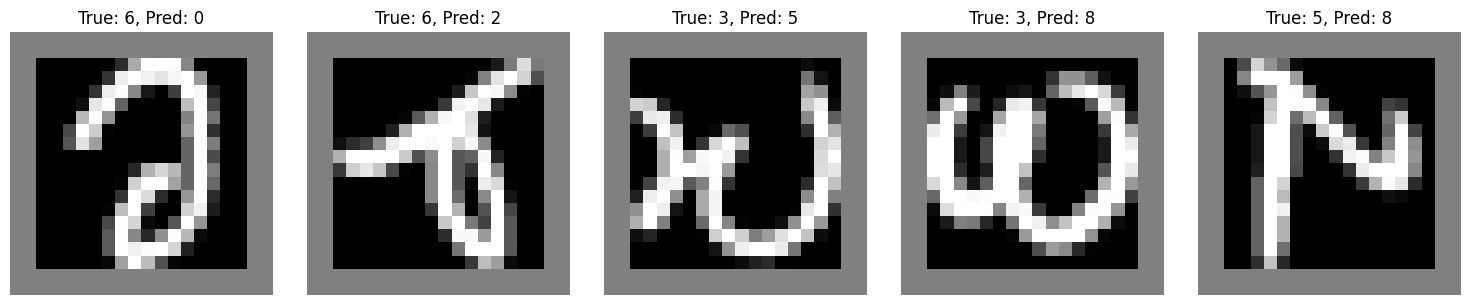

In [15]:
def classify_with_tangent_distance(test_image, training_images, training_labels):
    min_distance = float('inf')
    best_label = None
    for train_image, label in zip(training_images.T, training_labels):
        distance = tangent_distance(test_image, train_image)
        if distance < min_distance:
            min_distance = distance
            best_label = label
    return best_label

# Test the classification function
training_images = azip
training_labels = dzip
test_images = testzip.T
test_labels = dtest

correct = 0
misclassified_images = []
true_labels = []
predicted_labels = []

for i, test_image in enumerate(test_images):
    predicted_label = classify_with_tangent_distance(test_image, training_images, training_labels)
    if predicted_label == test_labels[i]:
        correct += 1
    else:
        misclassified_images.append(test_image)
        true_labels.append(test_labels[i])
        predicted_labels.append(predicted_label)

accuracy = correct / len(test_labels)
print(f"Accuracy: {accuracy}")

# Display misclassified images
if misclassified_images:
    ima2(misclassified_images, true_labels, predicted_labels, max_images=5)
else:
    print("No misclassified images to display.")